In [201]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
from nltk.stem import PorterStemmer
from sklearn.metrics import f1_score, accuracy_score


In [202]:
df = pd.read_csv('data.csv')
ps = PorterStemmer()

df.head(10)

,text,label
0,Subject: naturally irresistible your corporate...,spam
1,Subject: the stock trading gunslinger fanny i...,spam
2,Subject: unbelievable new homes made easy im ...,spam
3,Subject: 4 color printing special request add...,spam
4,"Subject: do not have money , get software cds ...",spam
5,"Subject: great nnews hello , welcome to medzo...",spam
6,Subject: here ' s a hot play in motion homela...,spam
7,Subject: save your money buy getting this thin...,spam
8,Subject: undeliverable : home based business f...,spam
9,Subject: save your money buy getting this thin...,spam


In [203]:
Y = 'label'
X = 'text'


In [204]:
def getClasses(data):
    classes = sorted(list(data[Y].unique()))
    return classes
getClasses(df)

['not spam', 'spam']

In [205]:
def getPrior(data):
    classes = getClasses(data)
    priors = [1] * len(classes)
    
    for i in range(len(classes)):
        label = classes[i]
        prior = len(data[data[Y] == label]) / len(data)
        priors[i] = prior
        
    return priors

getPrior(df)

[0.502, 0.498]

In [206]:
def cleanText(text):
    if not isinstance(text, str):
        return ''
    text = re.sub('[^A-Za-z ]+', '', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    text = text.split()  # Split into words
    text = [ps.stem(word) for word in text]
    
    text = list(set(text))  # Get unique words
    
    return text  # Join unique words into a single string

In [207]:
def processData(data):
    for i in range(len(data)):
        original_text = data.loc[i, 'text']  # Use .loc to access the value
        cleaned = cleanText(original_text)  # Clean the text
        data.loc[i, 'text'] = cleaned  # Replace the original text with the cleaned text
    return data


# print(train.index)

In [208]:
# process the content of each mail, remove spaces, digits, special characters and convert into array of words
df = processData(df)

# create train, test split with a random state for consistent output
train, test = train_test_split(df, test_size=0.1, random_state=123)

# reset index to prevent key errors
train = train.reset_index()
test = test.reset_index()

# flatten and create a list of unique words for laplace smoothing later in the program
allWords = [word for text in df['text'].dropna() for word in text]

allWords = list(set(allWords))

# len(allWords)

flattenedSpam = [word for text in train[train['label'] == 'spam']['text'].dropna() for word in text]
flattenedNotSpam = [word for text in train[train['label'] == 'not spam']['text'].dropna() for word in text]

flattened = {
    'spam': flattenedSpam,
    'not spam': flattenedNotSpam
}

# print(len(flattened['not spam']), len(flattened['spam']))
# print(len(flattenedNotSpam), len(flattenedSpam))
# print(train)
# print(train[train['label'] == 'not spam']['text'])


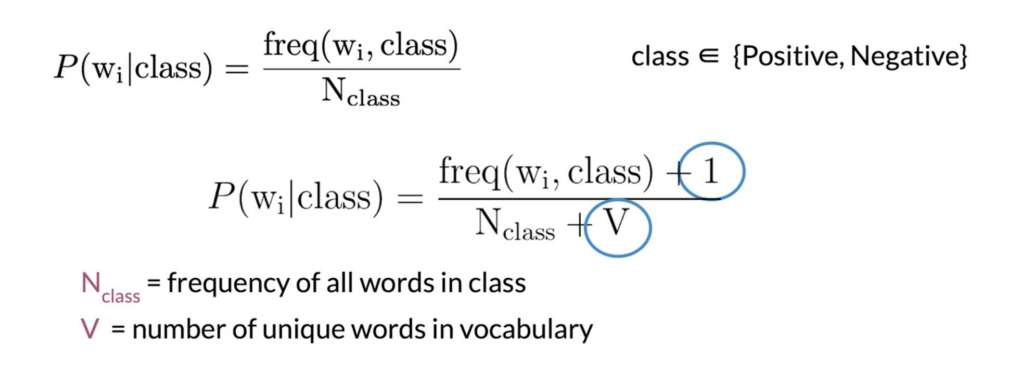

we apply laplace smoothing to prevent inaccuracies due to 0 probability (cases when the feature being considered doesnt exist under the class which leads to multiplication with 0)

In [209]:
def getLikelihood(data, word, label):
    # filteredData = data[data[Y] == label] # get data where label is equal to the class being considered, in our case this function will be called for spam and not spam
    filteredWords = flattened[label] # flatten 
    # flatten every word list in the data set into a 1d list of words, can use loop instead of this and check for each list
    # then check for the number of times the word occurs in it, in short check how many times the word occurs in the entire dataset where label=spam|not spam
    wordCount = filteredWords.count(word) 
    # frequency of all words in the class
    lenFilteredWords = len(filteredWords)
    # number of unique words in the vocabulary
    lenAllWords = len(allWords)
    # apply laplace smoothing and calculate class conditional probability (likelihood)
    likelihood = (wordCount + 1) / (lenFilteredWords + lenAllWords)
    
    return likelihood

In [210]:
def naiveBayes(train, test, ytest):
    
    classes = getClasses(train)
    priors = getPrior(train)
    predictions = []
    
    
    
    # loop through every test dat aset
    for i in range(len(test)):
        
        
        words = test.loc[i, 'text']
        
        posteriors = [1] * len(classes)
        
        # for each class, calculate the posterior probability and store it in posteriors array
        for j in range(len(classes)):
            
            likelihood = 1
            
            for k in range(len(words)):
                
                likelihood *= getLikelihood(
                    train,
                    words[k],
                    classes[j]
                )
                
            # P(Y|X) = Y(Y=class) * P(X|Y)
            likelihood *= priors[j]
            
            posteriors[j] = likelihood
            
        predictions.append(classes[np.argmax(posteriors)])
        
        # track epochs and predictions in real time
        print(f"{i + 1}/{len(test)} | prediction: {predictions[i]}, actual: {ytest[i]}")
        
        
    return predictions
        

In [211]:



# create expected output list for testing accuracy
ytest = list(test['label'])


predictions = naiveBayes(train, test, ytest)



# use sklearn to calculate accuracy
f1 = f1_score(ytest, predictions, pos_label="spam")
print(f"{f1 * 100}% F1 score")
print(f"{accuracy_score(ytest, predictions) * 100}% accuracy")

1/50 | prediction: spam, actual: spam
2/50 | prediction: not spam, actual: spam
3/50 | prediction: not spam, actual: spam
4/50 | prediction: not spam, actual: spam
5/50 | prediction: not spam, actual: spam
6/50 | prediction: not spam, actual: not spam
7/50 | prediction: not spam, actual: not spam
8/50 | prediction: spam, actual: spam
9/50 | prediction: not spam, actual: spam
10/50 | prediction: spam, actual: spam
11/50 | prediction: not spam, actual: not spam
12/50 | prediction: spam, actual: spam
13/50 | prediction: spam, actual: spam
14/50 | prediction: not spam, actual: not spam
15/50 | prediction: spam, actual: spam
16/50 | prediction: not spam, actual: not spam
17/50 | prediction: spam, actual: spam
18/50 | prediction: not spam, actual: not spam
19/50 | prediction: spam, actual: spam
20/50 | prediction: not spam, actual: spam
21/50 | prediction: spam, actual: spam
22/50 | prediction: not spam, actual: not spam
23/50 | prediction: spam, actual: spam
24/50 | prediction: not spam, ac